## Configurações Iniciais

In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

#clear_output()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.9 MB/s eta 0:00:00
Cloning into 'rl_facil'...
remote: Enumerating objects: 1863, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1863 (delta 81), reused 98 (delta 46), pack-reused 1699 (from 2)
Receiving objects: 100% (1863/1863), 33.47 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (1209/1209), done.


In [2]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from collections import deque

import numpy as np

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

def run_nstep_td(env, episodes, nsteps=1, lr=0.1, gamma=0.95, epsilon=0.1, verbose=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)
    assert isinstance(nsteps, int)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))

    gamma_array = np.array([ gamma**i for i in range(0,nsteps)])
    gamma_power_nstep = gamma**nsteps

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        # escolhe a próxima ação
        action = epsilon_greedy(Q, state, epsilon)

        # históricos de: estados, ações e recompensas
        hs = deque(maxlen=nsteps)
        ha = deque(maxlen=nsteps)
        hr = deque(maxlen=nsteps)

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # realiza a ação
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sum_rewards += reward

            # escolhe (antecipadamente) a ação do próximo estado
            next_action = epsilon_greedy(Q, next_state, epsilon)

            hs.append(state)
            ha.append(action)
            hr.append(reward)

            # se o histórico estiver completo com 'n' passos
            # vai fazer uma atualização no valor Q do estado mais antigo
            if len(hs) == nsteps:
                if terminated:
                    # para estados terminais
                    V_next_state = 0
                else:
                    # para estados não-terminais -- valor da próxima ação (já escolhida)
                    V_next_state = np.max(Q[next_state])

                # delta = (estimativa usando a nova recompensa) - estimativa antiga
                delta = ( sum(gamma_array * hr) + gamma_power_nstep * V_next_state ) - Q[hs[0],ha[0]]

                # atualiza a Q-table para o par (estado,ação) de n passos atrás
                Q[hs[0],ha[0]] += lr * delta

            # preparação para avançar mais um passo
            # lembrar que a ação a ser realizada já está escolhida
            state = next_state
            action = next_action
            # fim do laço por episódio

        # ao fim do episódio, atualiza o Q dos estados que restaram no histórico

        # é igual ao V_next_state, exceto em episódios muito curtos (com duração menor que "nsteps")
        V_end_state = 0 if terminated else np.max(Q[next_state])

        # inferior ao "nsteps" apenas em episódios muito curtos
        steps_to_end = min(nsteps, len(hs))
        for j in range(steps_to_end-1,0,-1):
            hs.popleft()
            ha.popleft()
            hr.popleft()
            delta = ( sum(gamma_array[0:j]*hr) + gamma_array[j]*V_end_state ) - Q[hs[0],ha[0]]
            Q[hs[0],ha[0]] += lr * delta

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if verbose and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q


from envs import RacetrackEnv
from envs.wrappers import ObservationDiscretizerWrapper

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable


## 1 - TD Learning Off-Policy de n Passos

O TD Learning Off-Policy de n passos é uma extensão do TD Learning que utiliza uma sequência de *n* passos para atualizar a estimativa do $Q(s,a)$.

### Relembrando o Off-Policy
No aprendizado off-policy, a política de comportamento (que escolhe as ações) é diferente da política alvo (que é avaliada). Um exemplo clássico é o Q-Learning.

### TD Learning On-Policy
No TD Learning on-policy, a mesma política é usada tanto para escolher as ações quanto para avaliar a política. Um exemplo é o SARSA.

### Correção no TD Learning Off-Policy
A correção no TD Learning off-policy é feita através de métodos como o Ordinary Importance Sampling e o Weighted Importance Sampling.

### Exemplos Simples
Vamos ver exemplos de como essa correção é calculada em episódios pequenos, de 1 até 3 passos.

#### Ordinary Importance Sampling
Para **$n=1$**:
- experiência: $s, a, r_1, s_1, a_1$
- estimativa: $Q_{target} = r_1 + \gamma . Q(s_1,a_1) * \frac{\pi(a_1|s_1)}{b(a_1|s_1)}$

#### Weighted Importance Sampling
Para **$n=2$**:
- experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2$
- estimativa: $Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . Q(s_2,a_2) * \frac{\pi(a_1|s_1)\pi(a_2|s_2)}{b(a_1|s_1)b(a_2|s_2)}$

### Implementação
Vamos implementar as variantes do off-policy:
- Ordinary Importance Sampling
- Weighted Importance Sampling
- Pesos Truncados


In [3]:
# para ambientes gymnasium
#ENV_NAME, r_max = "Taxi-v3", 10
#ENV_NAME, r_max = "CliffWalking-v0", 0
#ENV_NAME, r_max = "FrozenLake-v1", 0
ENV_NAME, r_max = "RaceTrack-v0", 0

env = gym.make(ENV_NAME)

# para ambientes instanciados diretamente
# atenção: vale a pena aplicar um TimeLimit
#env = RacetrackEnv()
#r_max = 0

EPISODES = 5_000
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 5

# Roda o algoritmo "n-step TD"
rewards1, qtable1 = run_nstep_td(env, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Episode 100 Average Reward (last 100): -115.920
Episode 200 Average Reward (last 100): -109.420
Episode 300 Average Reward (last 100): -99.840
Episode 400 Average Reward (last 100): -89.780
Episode 500 Average Reward (last 100): -91.800
Episode 600 Average Reward (last 100): -86.950
Episode 700 Average Reward (last 100): -85.470
Episode 800 Average Reward (last 100): -75.670
Episode 900 Average Reward (last 100): -67.610
Episode 1000 Average Reward (last 100): -65.530
Episode 1100 Average Reward (last 100): -57.240
Episode 1200 Average Reward (last 100): -59.400
Episode 1300 Average Reward (last 100): -59.680
Episode 1400 Average Reward (last 100): -50.710
Episode 1500 Average Reward (last 100): -45.750
Episode 1600 Average Reward (last 100): -49.990
Episode 1700 Average Reward (last 100): -50.080
Episode 1800 Average Reward (last 100): -47.730
Episode 1900 Average Reward (last 100): -41.530
Episode 2000 Average Reward (last 100): -54.430
Episode 2100 Average Reward (last 100): -40.750

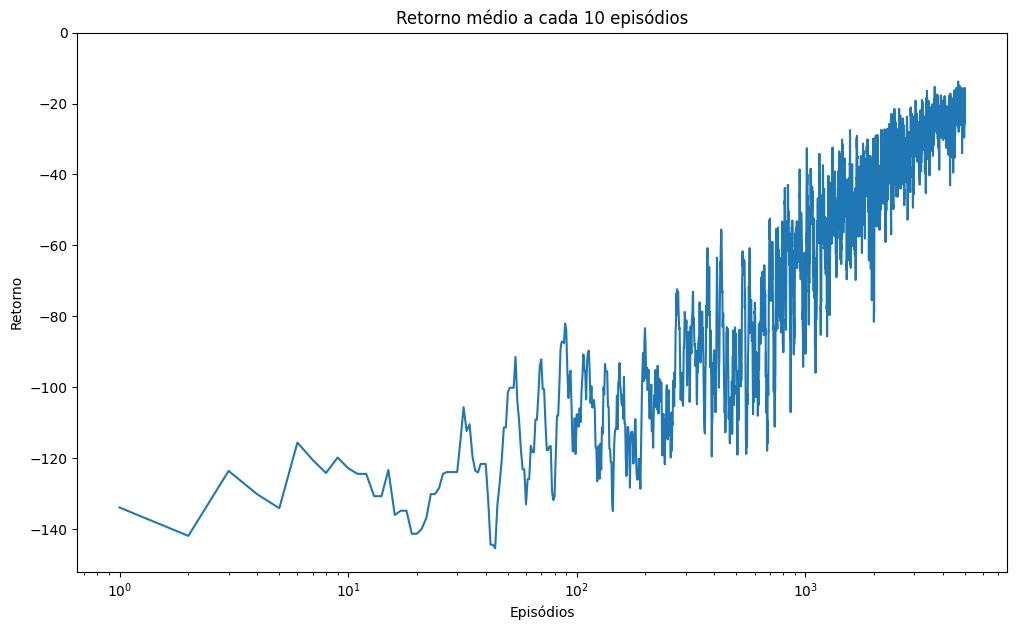

In [4]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max, x_log_scale=True)

In [5]:
evaluate_qtable_policy(env, qtable1, 10, epsilon=0.1, verbose=True);

Episódio 1: -34.0
Episódio 2: -14.0
Episódio 3: -23.0
Episódio 4: -16.0
Episódio 5: -12.0
Episódio 6: -23.0
Episódio 7: -20.0
Episódio 8: -16.0
Episódio 9: -17.0
Episódio 10: -17.0
Retorno médio (por episódio): -19.20, episódios: 10, total de passos: 202


In [6]:
# atenção: precisa passar a ID do ambiente no gymnasium ou instanciar diretamente um novo ambiente com o render_mode "rgb_array"
record_video_qtable(ENV_NAME, qtable1, episodes=3, folder='videos/', prefix='nstep-td')
#record_video_qtable(RacetrackEnv(render_mode="rgb_array"), qtable1, episodes=3, folder='videos/', prefix='nstep-td')

In [7]:
display_videos_from_path('./videos', prefix='nstep-td')

A seguir, vamos rodar alguns experimentos variando a quantidade de passos:

In [8]:
RUNS = 3
results1 = []
for nstep in [1, 2, 3]:
    results1.append( repeated_exec(RUNS, f"{nstep}-step TD (LR={LR})", run_nstep_td, env, EPISODES, nstep, LR) )
    clear_output()

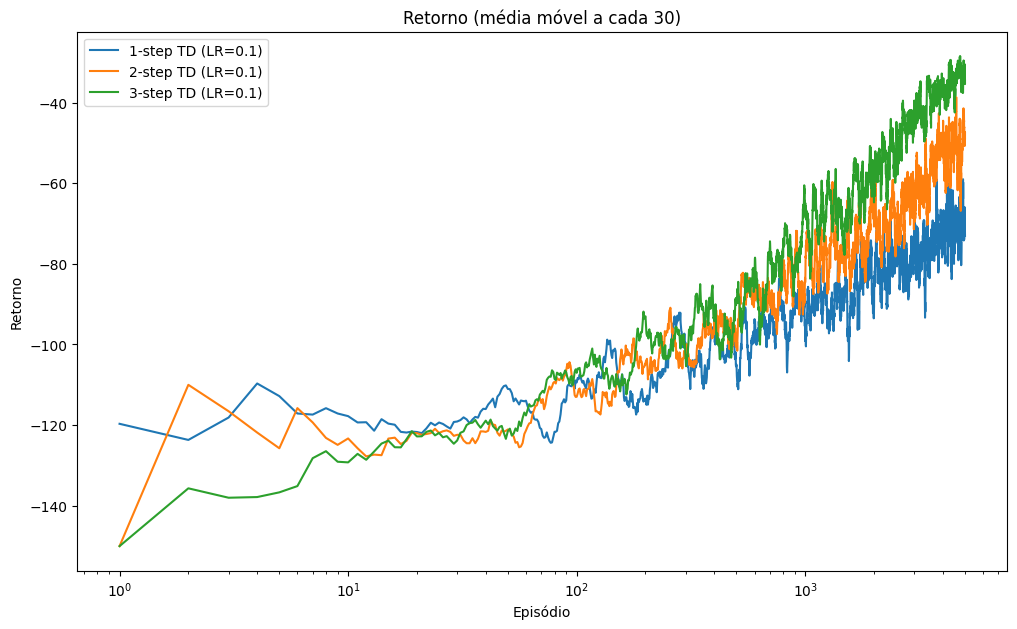

In [9]:
plot_multiple_results(results1, window=30, x_log_scale=True)

# Agora com o ambiente Cliffwalking

Episode 100 Average Reward (last 100): -98.440
Episode 200 Average Reward (last 100): -23.070
Episode 300 Average Reward (last 100): -19.810
Episode 400 Average Reward (last 100): -21.770
Episode 500 Average Reward (last 100): -56.710
Episode 600 Average Reward (last 100): -33.150
Episode 700 Average Reward (last 100): -24.760
Episode 800 Average Reward (last 100): -25.260
Episode 900 Average Reward (last 100): -97.890
Episode 1000 Average Reward (last 100): -27.600
Episode 1100 Average Reward (last 100): -24.270
Episode 1200 Average Reward (last 100): -39.220
Episode 1300 Average Reward (last 100): -23.120
Episode 1400 Average Reward (last 100): -23.470
Episode 1500 Average Reward (last 100): -27.760
Episode 1600 Average Reward (last 100): -22.660
Episode 1700 Average Reward (last 100): -22.510
Episode 1800 Average Reward (last 100): -25.460
Episode 1900 Average Reward (last 100): -23.180
Episode 2000 Average Reward (last 100): -20.270
Episode 2100 Average Reward (last 100): -21.400
E

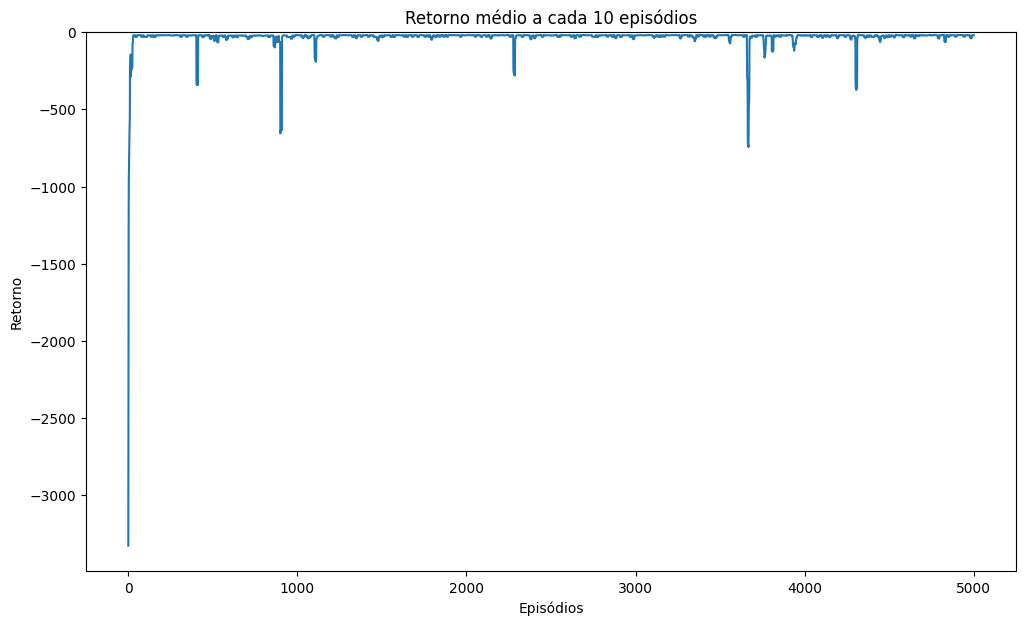

Episódio 1: -18.0
Episódio 2: -20.0
Episódio 3: -19.0
Episódio 4: -20.0
Episódio 5: -18.0
Episódio 6: -18.0
Episódio 7: -18.0
Episódio 8: -17.0
Episódio 9: -23.0
Episódio 10: -17.0
Retorno médio (por episódio): -18.80, episódios: 10, total de passos: 188


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [10]:
import numpy as np

ENV_NAME, r_max = "CliffWalking-v0", 0

env = gym.make(ENV_NAME)

EPISODES = 5_000
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 5

# Roda o algoritmo "n-step TD" no ambiente CliffWalking
rewards1, qtable1 = run_nstep_td(env, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max, None)
evaluate_qtable_policy(env, qtable1, 10, epsilon=0.1, verbose=True);
record_video_qtable(ENV_NAME, qtable1, episodes=3, folder='videos/', prefix='nstep-td-cliffwalking')
display_videos_from_path('./videos', prefix='nstep-td-cliffwalking')

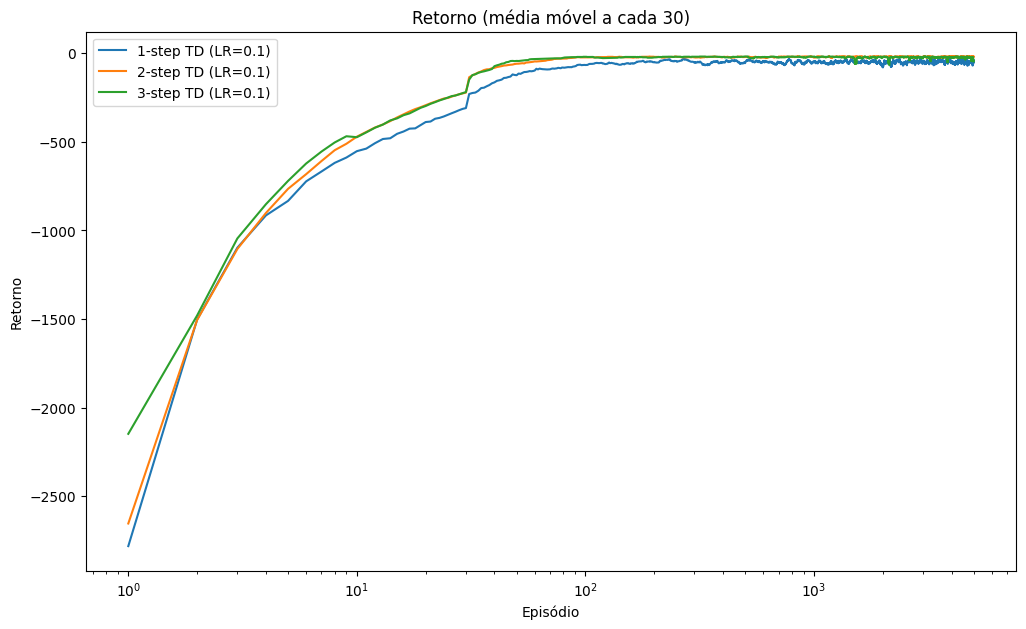

In [11]:
# Experimentos variando a quantidade de passos no CliffWalking
RUNS = 3
results1 = []
for nstep in [1, 2, 3]:
    results1.append(repeated_exec(RUNS, f"{nstep}-step TD (LR={LR})", run_nstep_td, env, EPISODES, nstep, LR))
    clear_output()
plot_multiple_results(results1, window=30, x_log_scale=True)


## 2 - Lidando com Estados Contínuos

Vamos usar os mesmos algoritmos de antes, baseados em Q-Table, para lidar com ambientes de estados contínuos.

Para isso, vamos usar um *wrapper* que discretiza os estados desses ambientes.

Primeiramente, vamos analisar, abaixo, o espaço de estados de um ambiente contínuo:

In [12]:
ENV_NAME = "CartPole-v1"
#ENV_NAME, r_max = "Taxi-v3" *** LEMBRAR DE COMENTAR OS BINS E env2b -> env2a
#ENV_NAME, r_max = "CliffWalking-v0"
#ENV_NAME, r_max = "FrozenLake-v1"
r_max_plot = 200

env2a = gym.make(ENV_NAME)

# vamos ver como é um estado deste ambiente?
print("Espaço de estados/observações: ", env2a.observation_space)
print("  - formato: ", env2a.observation_space.shape)
print("  - exemplo: ", env2a.reset())

Espaço de estados/observações:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  - formato:  (4,)
  - exemplo:  (array([ 0.02397192,  0.03969923, -0.04888153, -0.02294481], dtype=float32), {})


Abaixo, nós encapsulamos o ambiente contínuo em um wrapper para discretizá-lo.

Os parâmetros indicam quantos valores discretos foram usados para representar cada uma das dimensões do estado.

Como resultado, o espaço de estados torna-se do tipo `Discrete`, o que indica que cada "estado" é representado como um único número inteiro.

In [13]:
# Encapsula o ambiente em nosso wrapper
# atenção para o parâmetro BINS: deve ter um valor para cada componente do estado
BINS = [5, 30, 30, 30]
env2b = ObservationDiscretizerWrapper(env2a, BINS)

env2b.observation_space

/content/rl_facil/envs/wrappers.py:57: RuntimeWarning: overflow encountered in scalar multiply
  min_value = env_space.low[i] if not np.isneginf(env_space.low[i]) else 2*np.finfo(np.float64).min
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


Discrete(135000)

Agora, podemos rodar treinamentos com quaisquer dos algoritmos que temos visto. Vamos rodar o *TD Learning de n passos*:

In [14]:
EPISODES = 5_000
LR = 0.2
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 4

rewards2, qtable2 = run_nstep_td(env2b, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)

print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Episode 100 Average Reward (last 100): 19.470
Episode 200 Average Reward (last 100): 28.010
Episode 300 Average Reward (last 100): 38.310
Episode 400 Average Reward (last 100): 34.370
Episode 500 Average Reward (last 100): 33.960
Episode 600 Average Reward (last 100): 34.190
Episode 700 Average Reward (last 100): 35.950
Episode 800 Average Reward (last 100): 35.780
Episode 900 Average Reward (last 100): 32.810
Episode 1000 Average Reward (last 100): 34.300
Episode 1100 Average Reward (last 100): 31.330
Episode 1200 Average Reward (last 100): 40.190
Episode 1300 Average Reward (last 100): 34.930
Episode 1400 Average Reward (last 100): 34.140
Episode 1500 Average Reward (last 100): 33.420
Episode 1600 Average Reward (last 100): 33.030
Episode 1700 Average Reward (last 100): 37.990
Episode 1800 Average Reward (last 100): 38.290
Episode 1900 Average Reward (last 100): 31.070
Episode 2000 Average Reward (last 100): 35.830
Episode 2100 Average Reward (last 100): 36.610
Episode 2200 Average R

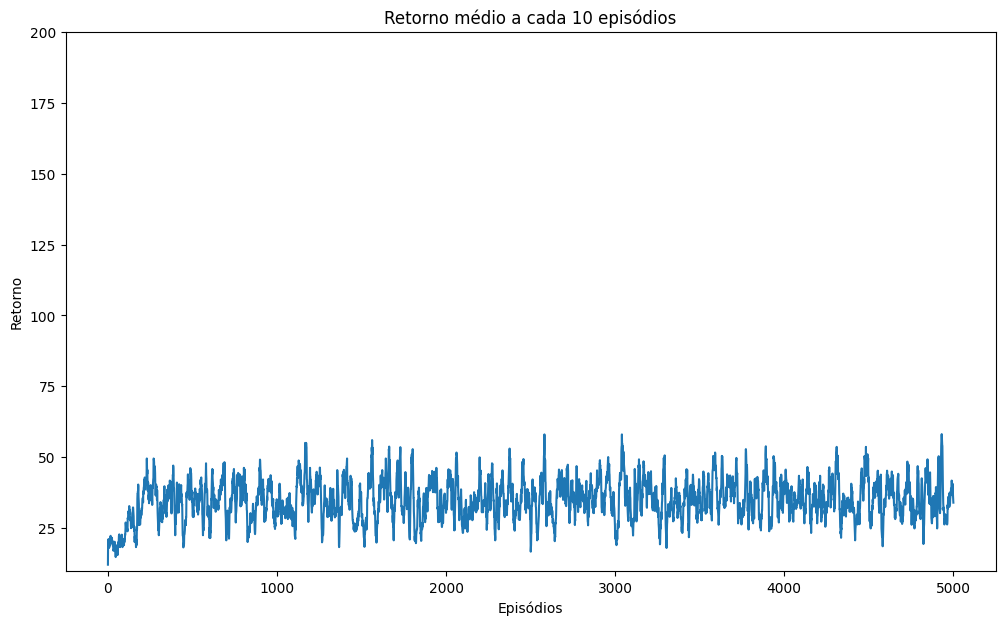

In [15]:
# Gera um gráfico de episódios x retornos (não descontados)
plot_result(rewards2, r_max_plot)

In [16]:
# Faz alguns testes, usando a tabela de forma greedy
evaluate_qtable_policy(env2b, qtable2, 10, 0.0, verbose=True)

Episódio 1: 35.0
Episódio 2: 46.0
Episódio 3: 37.0
Episódio 4: 41.0
Episódio 5: 41.0
Episódio 6: 45.0
Episódio 7: 40.0
Episódio 8: 29.0
Episódio 9: 53.0
Episódio 10: 32.0
Retorno médio (por episódio): 39.90, episódios: 10, total de passos: 399


(39.9, [35.0, 46.0, 37.0, 41.0, 41.0, 45.0, 40.0, 29.0, 53.0, 32.0])

In [17]:
# Salva vídeo
# Atenção: é recomendado criar nova instância do ambiente e do wrapper!
env_test = gym.make(ENV_NAME, render_mode="rgb_array")
env_test = ObservationDiscretizerWrapper(env_test, BINS)
record_video_qtable(env_test, qtable2, episodes=3, folder='videos/', prefix='nstep-cartpole')

In [18]:
display_videos_from_path('./videos', prefix='nstep-cartpole')

## 3 - Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

In [19]:
import optuna

### 3.1 - Ambiente Discreto

Este é o caso mais simples, porque não precisamos aplicar nenhum wrapper.

Primeiro, você precisa fazer uma função que receber um parâmetro do tipo `Trial` (definido no optuna) e retorna uma medida de desempenho.

Dentro da função, você usa o objeto *trial* para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [20]:
def train_nstep_td_racetrack(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    gamma  = trial.suggest_float('gamma', 0.90, 1.00)
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # outra opção trial.suggest_categorical('param', ['value1', 'value2'])

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente Racetrack, mas insere-o em um wrapper para limitar o tamanho do episódio
    env = gym.make("RaceTrack-v0")

    # Roda o algoritmo "n-step TD"
    rewards, qtable = run_nstep_td(env, EPISODES, nsteps, lr, gamma, eps, verbose=False)

    # Retorna a média dos últimos 20 episódios
    return np.mean(rewards[-20:])


In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(train_nstep_td_racetrack, n_trials=3)

print("Melhores parâmetros:")
print(study.best_params)

[I 2025-02-28 16:00:24,200] A new study created in memory with name: no-name-f22c1bdb-165f-4ed6-a100-3e2d35f1b819



TRIAL #0: {'epsilon': 0.03756110960756678, 'gamma': 0.9225805439027929, 'lr': 0.019240400860528823, 'nsteps': 4}


[I 2025-02-28 16:00:46,673] Trial 0 finished with value: -57.8 and parameters: {'epsilon': 0.03756110960756678, 'gamma': 0.9225805439027929, 'lr': 0.019240400860528823, 'nsteps': 4}. Best is trial 0 with value: -57.8.



TRIAL #1: {'epsilon': 0.16971827845390336, 'gamma': 0.9558780194258578, 'lr': 0.007995115709581037, 'nsteps': 4}


[I 2025-02-28 16:01:11,831] Trial 1 finished with value: -103.45 and parameters: {'epsilon': 0.16971827845390336, 'gamma': 0.9558780194258578, 'lr': 0.007995115709581037, 'nsteps': 4}. Best is trial 0 with value: -57.8.



TRIAL #2: {'epsilon': 0.021690339947406413, 'gamma': 0.9286270786694294, 'lr': 0.0473844621512748, 'nsteps': 12}


[I 2025-02-28 16:01:25,986] Trial 2 finished with value: -21.3 and parameters: {'epsilon': 0.021690339947406413, 'gamma': 0.9286270786694294, 'lr': 0.0473844621512748, 'nsteps': 12}. Best is trial 2 with value: -21.3.


Melhores parâmetros:
{'epsilon': 0.021690339947406413, 'gamma': 0.9286270786694294, 'lr': 0.0473844621512748, 'nsteps': 12}


In [22]:
import numpy as np
def train_nstep_td_cliffwalking(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    gamma  = trial.suggest_float('gamma', 0.90, 1.00)
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente CliffWalking-v0
    env = gym.make("CliffWalking-v0")

    # Roda o algoritmo "n-step TD"
    rewards, qtable = run_nstep_td(env, EPISODES, nsteps, lr, gamma, eps, verbose=False)

    # Retorna a média dos últimos 20 episódios
    return np.mean(rewards[-20:])

study = optuna.create_study(direction='maximize')
study.optimize(train_nstep_td_cliffwalking, n_trials=3)

print("Melhores parâmetros:")
study.best_params


[I 2025-02-28 16:01:58,560] A new study created in memory with name: no-name-092ee8d2-a185-4a88-bfe9-6fb416df8a48



TRIAL #0: {'epsilon': 0.09200255657392863, 'gamma': 0.9744634153039682, 'lr': 0.7551859130520904, 'nsteps': 10}


[I 2025-02-28 16:02:13,817] Trial 0 finished with value: -37.2 and parameters: {'epsilon': 0.09200255657392863, 'gamma': 0.9744634153039682, 'lr': 0.7551859130520904, 'nsteps': 10}. Best is trial 0 with value: -37.2.



TRIAL #1: {'epsilon': 0.19174640518483332, 'gamma': 0.9992437829302898, 'lr': 0.007657260047950955, 'nsteps': 11}


[I 2025-02-28 16:02:18,870] Trial 1 finished with value: -32.35 and parameters: {'epsilon': 0.19174640518483332, 'gamma': 0.9992437829302898, 'lr': 0.007657260047950955, 'nsteps': 11}. Best is trial 1 with value: -32.35.



TRIAL #2: {'epsilon': 0.12320132657065741, 'gamma': 0.956110028273262, 'lr': 0.003537200677599745, 'nsteps': 15}


[I 2025-02-28 16:02:25,019] Trial 2 finished with value: -19.15 and parameters: {'epsilon': 0.12320132657065741, 'gamma': 0.956110028273262, 'lr': 0.003537200677599745, 'nsteps': 15}. Best is trial 2 with value: -19.15.


Melhores parâmetros:


{'epsilon': 0.12320132657065741,
 'gamma': 0.956110028273262,
 'lr': 0.003537200677599745,
 'nsteps': 15}

### 3.2 - Ambiente Contínuo

Para ambientes contínuos, precisamos encapsular o ambiente em um wrapper para discretizar os estados.

Primeiro, você precisa fazer uma função que receber um parâmetro do tipo `Trial` (definido no optuna) e retorna uma medida de desempenho.

Dentro da função, você usa o objeto *trial* para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [23]:
def train_nstep_td_cartpole(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    gamma  = trial.suggest_float('gamma', 0.90, 1.00)
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # outra opção trial.suggest_categorical('param', ['value1', 'value2'])

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente CartPole, mas insere-o em um wrapper para discretizar os estados
    env = gym.make("CartPole-v1")
    BINS = [5, 30, 30, 30]
    env = ObservationDiscretizerWrapper(env, BINS)

    # Roda o algoritmo "n-step TD"
    rewards, qtable = run_nstep_td(env, EPISODES, nsteps, lr, gamma, eps, verbose=False)

    # Retorna a média dos últimos 20 episódios
    return np.mean(rewards[-20:])


In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(train_nstep_td_cartpole, n_trials=3)

print("Melhores parâmetros:")
print(study.best_params)

[I 2025-02-28 16:02:35,933] A new study created in memory with name: no-name-ec2013f3-c4b4-4657-83ca-c8cbef7a9dce
/content/rl_facil/envs/wrappers.py:57: RuntimeWarning: overflow encountered in scalar multiply
  min_value = env_space.low[i] if not np.isneginf(env_space.low[i]) else 2*np.finfo(np.float64).min
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start



TRIAL #0: {'epsilon': 0.18906454818139085, 'gamma': 0.9120911855034726, 'lr': 0.0016770318812622102, 'nsteps': 6}


[I 2025-02-28 16:02:40,540] Trial 0 finished with value: 10.3 and parameters: {'epsilon': 0.18906454818139085, 'gamma': 0.9120911855034726, 'lr': 0.0016770318812622102, 'nsteps': 6}. Best is trial 0 with value: 10.3.



TRIAL #1: {'epsilon': 0.18088594171540026, 'gamma': 0.9085199795794213, 'lr': 0.08953489818789677, 'nsteps': 8}


[I 2025-02-28 16:02:56,083] Trial 1 finished with value: 44.5 and parameters: {'epsilon': 0.18088594171540026, 'gamma': 0.9085199795794213, 'lr': 0.08953489818789677, 'nsteps': 8}. Best is trial 1 with value: 44.5.



TRIAL #2: {'epsilon': 0.168299625262144, 'gamma': 0.9823239808158479, 'lr': 0.013307654440556467, 'nsteps': 9}


[I 2025-02-28 16:03:11,522] Trial 2 finished with value: 42.3 and parameters: {'epsilon': 0.168299625262144, 'gamma': 0.9823239808158479, 'lr': 0.013307654440556467, 'nsteps': 9}. Best is trial 1 with value: 44.5.


Melhores parâmetros:
{'epsilon': 0.18088594171540026, 'gamma': 0.9085199795794213, 'lr': 0.08953489818789677, 'nsteps': 8}


## 4 - Experimentos Completos

Agora que você descobriu bons parâmetros, que tal rodar um treinamento mais longo com o seu algoritmo?

Para cada ambiente, comparar os parâmetros default com os parâmetros otimizados.


### Racetrack

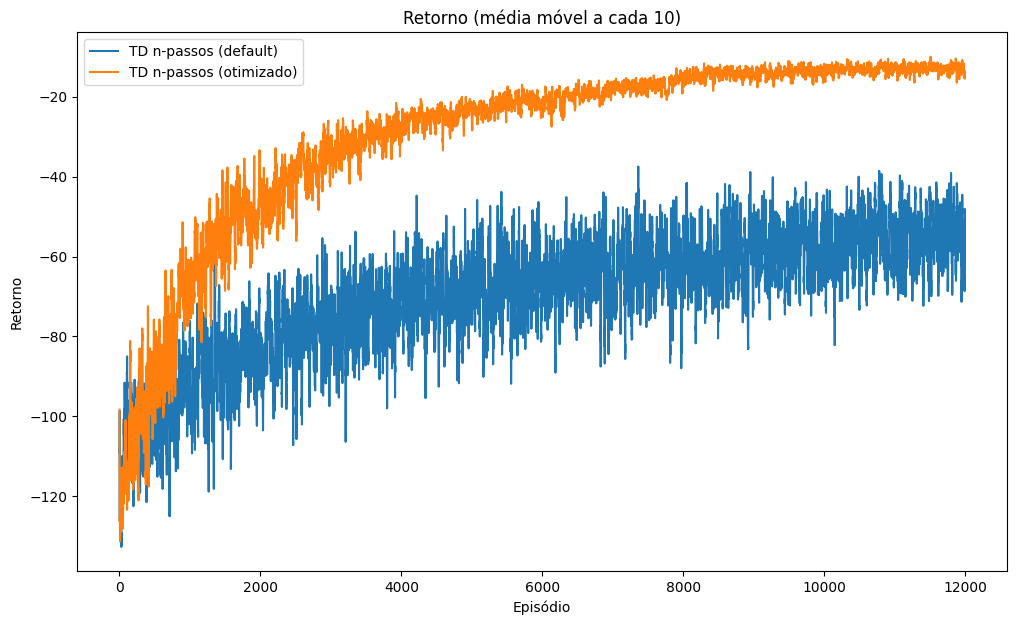

In [25]:
#env_race = TimeLimit(RacetrackEnv(), 500)
env_race = gym.make("RaceTrack-v0")
NUM_EPISODES = 12_000
RUNS = 3

results = []

results.append( repeated_exec(RUNS, f"TD n-passos (default)", run_nstep_td, env_race, NUM_EPISODES) )
#clear_output()

results.append( repeated_exec(RUNS, f"TD n-passos (otimizado)", run_nstep_td, env_race, NUM_EPISODES, **study.best_params) )
clear_output()

plot_multiple_results(results, x_log_scale=False)

### CartPole

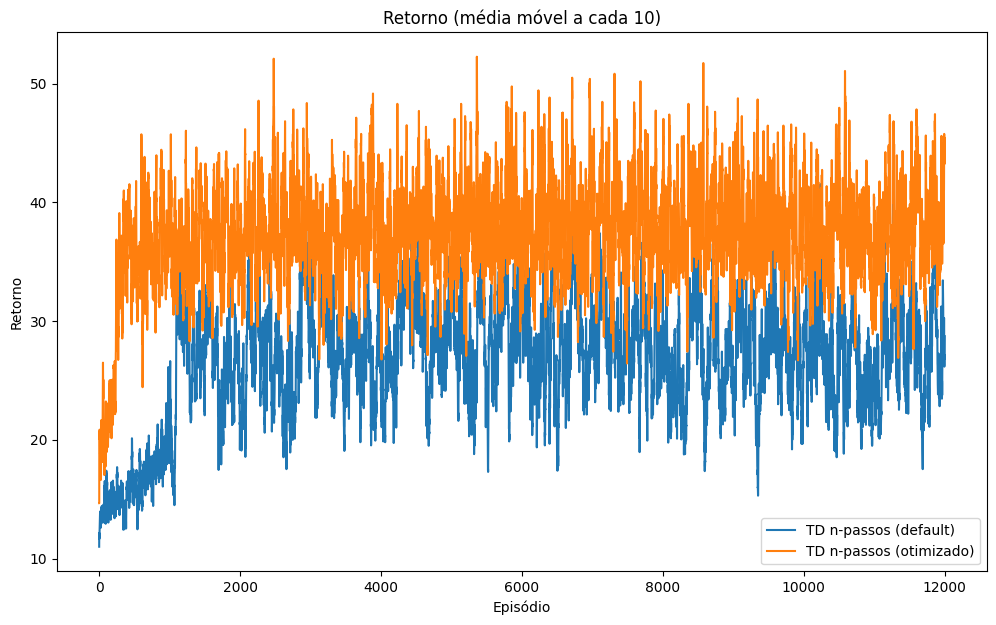

In [26]:
env_cart = gym.make("CartPole-v1")
NUM_EPISODES = 12_000
RUNS = 3

results = []

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [30,30,30,30])
results.append( repeated_exec(RUNS, f"TD n-passos (default)", run_nstep_td, wrapped_env_cart, NUM_EPISODES, auto_load=True) )
#clear_output()

params = study.best_params

bins1 = [30, 30, 30, 30]

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, bins1)
results.append( repeated_exec(RUNS, f"TD n-passos (otimizado)", run_nstep_td, wrapped_env_cart, NUM_EPISODES, epsilon=params['epsilon'], lr=params['lr'], nsteps=params['nsteps'], auto_load=True) )
clear_output()

plot_multiple_results(results, x_log_scale=False)

# Cliffwalking

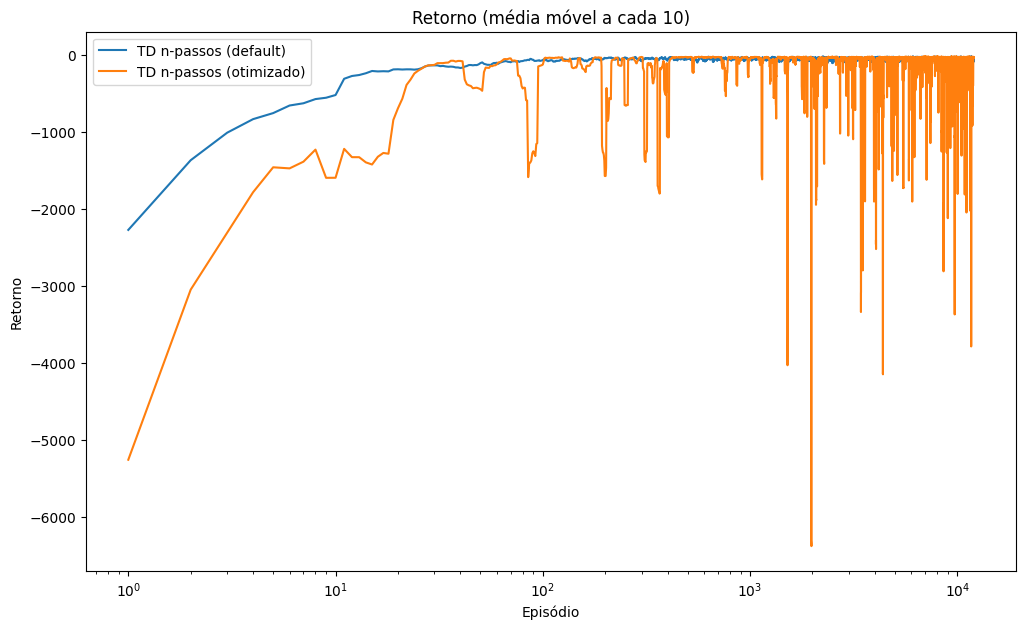

In [28]:
env_cliff = gym.make("CliffWalking-v0")
NUM_EPISODES = 12_000
RUNS = 3

results = []

results.append(repeated_exec(RUNS, f"TD n-passos (default)", run_nstep_td, env_cliff, NUM_EPISODES))
#clear_output()

results.append(repeated_exec(RUNS, f"TD n-passos (otimizado)", run_nstep_td, env_cliff, NUM_EPISODES, **study.best_params))
clear_output()

plot_multiple_results(results, x_log_scale=True)


# Observações finais

Como podemos observar nos resultados obtidos nesses experimentos com o TD n step off-policy, esse tipo de algoritmo tem bons retornos em ambientes de teste discretos, porém não tem muitos ganhos de aprendizado em ambientes contínuos